Comenzando cargando las librerías necesarias

In [1]:
import matplotlib.pyplot
import numpy
import pandas
import random
import sklearn.ensemble
import sklearn.metrics
import sklearn.model_selection
import sklearn.naive_bayes
import sklearn.tree
import vecstack
import xgboost

A continuación definimos algunas funciones de utilidad y cargamos el conjunto de datos discretizado.

In [2]:
# Definición de función para discretizar variables por cuantiles
def DiscretizarPorCuantiles(datos, columnas, intervalos):
    datosNuevos = datos.copy()
    informacion = {}
    for columna in columnas:
        paso      = 1 / intervalos
        cuantiles = numpy.arange(0, 1.0 + paso, paso)
        etiquetas = list(map(str, numpy.arange(1, intervalos + 1)))

        (nuevosDatos, intervalosEtiquetas) = pandas.qcut(x=datos[columna], q=cuantiles, labels=etiquetas, retbins=True)
        datosNuevos[columna] = nuevosDatos.cat.codes
        informacion[columna] = { "cuantiles": cuantiles, "etiquetas": etiquetas, "intervalos": intervalosEtiquetas }
    return [datosNuevos, informacion ]

# Definición de función para calcular métricas a partir de un modelo
def CalcularMetricas(observaciones, predicciones):
    matriz_confusion = sklearn.metrics.confusion_matrix(observaciones, predicciones)
    metricas  = {
        "accuracy": sklearn.metrics.accuracy_score(observaciones, predicciones),
        "roc_auc": sklearn.metrics.roc_auc_score(observaciones, predicciones),
        "precision": sklearn.metrics.precision_score(observaciones, predicciones),
        "recall": sklearn.metrics.recall_score(observaciones, predicciones),
        "f1": sklearn.metrics.f1_score(observaciones, predicciones),
        "f2": sklearn.metrics.fbeta_score(observaciones, predicciones, beta = 2),
        "TP": matriz_confusion[1, 1],
        "FP": matriz_confusion[0, 1],
        "TN": matriz_confusion[0, 0],
        "FN": matriz_confusion[1, 0]        
    }
    return metricas  

# Función para entrenrar un modelos y explorar parámetros utilizando k-Fold Cross Validation
def EvaluarPerformance(gridSearch, parametros):
    # Generar DataFrame de resultados
    resultadosDF  = []
    resultados    = gridSearch.cv_results_
    combinaciones = resultados["params"]    
    for i in range(0, gridSearch.n_splits_):
        keyName = "split" + str(i) + "_test_score"
        if keyName in resultados:
            valores = resultados[keyName]
            for j in range(0, len(combinaciones)):
                datosCombinacion = [ i ]
                datosCombinacion.append(valores[j])
                for parametro in parametros.keys():
                    datosCombinacion.append(combinaciones[j][parametro])
                resultadosDF.append(datosCombinacion)

    columnas  = ["k", "valor"]
    columnas.extend(parametros.keys())
    groupcols = list(parametros.keys())
    resultadosDF = pandas.DataFrame.from_records(resultadosDF, columns=columnas)\
        .groupby(groupcols, as_index=False)\
        .aggregate({'valor':{'media':'mean', 'desvio':'std'}})
    return resultadosDF

# Lectura de set de datos discretizado
setDatosOriginal = pandas.read_csv(filepath_or_buffer = "input/SetDatosDiscretizado.csv", sep = "\t",
                                       na_values = "NA")
setDatosDiscretizado, informacion = DiscretizarPorCuantiles(datos=setDatosOriginal, columnas=['age','height','weight'], intervalos=10)

# Separo los features del data frame del target a aprender
atributos = setDatosDiscretizado.drop(columns = [ "id", "cardio" ])
objetivo  = setDatosDiscretizado['cardio']


Luego, separamos el conjunto de datos en conjunto de *desarrollo* y conjunto de *test*

In [3]:
# Separar en sets de desarrollo (entrenamiento + validacion) y testeo
atributosDesarrollo, atributosTest, objetivoDesarrollo, objetivoTest = \
    sklearn.model_selection.train_test_split(atributos, objetivo, train_size = 0.8, test_size = 0.2, random_state = 0)

# Separar el set de desarrollo en sets de entrenamiento y validacion
atributosEntrenamiento, atributosValidacion, objetivoEntrenamiento, objetivoValidacion = \
    sklearn.model_selection.train_test_split(atributosDesarrollo, objetivoDesarrollo,
                                             train_size = 0.8, test_size = 0.2, random_state = 0)

# 1. Clasificación utilizando *Random Forest*

In [20]:
clasificadorRandomForest = sklearn.ensemble.RandomForestClassifier(n_estimators=2, 
                                                                   criterion="gini", 
                                                                   max_depth=6,                                                                    
                                                                   random_state=0)

A continuación, exploramos parámetros del clasificador utilizando 5-Fold Cross Validation.

In [21]:
fbeta_scorer = sklearn.metrics.make_scorer(sklearn.metrics.fbeta_score, beta=2)
parametrosRF = { "max_features": numpy.arange(1, len(atributosDesarrollo.columns)+1) }
gridSearchRF = sklearn.model_selection.GridSearchCV(estimator = clasificadorRandomForest, cv = 5, n_jobs = 4, 
                                                    param_grid = parametrosRF, scoring = fbeta_scorer,
                                                    return_train_score=False)
gridSearchRF.fit(X=atributosDesarrollo, y=objetivoDesarrollo)
performanceRF = EvaluarPerformance(gridSearchRF, parametrosRF)
print(performanceRF)

   max_features     valor          
                    media    desvio
0             1  0.643711  0.040365
1             2  0.689355  0.020785
2             3  0.666014  0.010179
3             4  0.684345  0.010496
4             5  0.671155  0.016773
5             6  0.684125  0.011027
6             7  0.691689  0.002309
7             8  0.683879  0.016584
8             9  0.688741  0.014385
9            10  0.689277  0.019156
10           11  0.685770  0.014370


/opt/anaconda3/envs/aprendizaje-automatico/lib/python3.7/site-packages/pandas/core/groupby/generic.py:1315: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


Ahora calculamos métricas utilizando el conjunto de test.

In [6]:
prediccionesRF = gridSearchRF.best_estimator_.predict(atributosTest)
metricasRF     = CalcularMetricas(objetivoTest, prediccionesRF)
print(metricasRF)

{'accuracy': 0.7302857142857143, 'roc_auc': 0.7294990233642905, 'precision': 0.7696120321312596, 'recall': 0.6496897994517385, 'f1': 0.7045845720544515, 'f2': 0.6705882352941176, 'TP': 4503, 'FP': 1348, 'TN': 5721, 'FN': 2428}


Finalmente, graficamos la importancia de cada uno de los atributos a los efectos del ajuste según los resultados devueltos por el clasificador *Random Forest*.

/opt/anaconda3/envs/aprendizaje-automatico/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


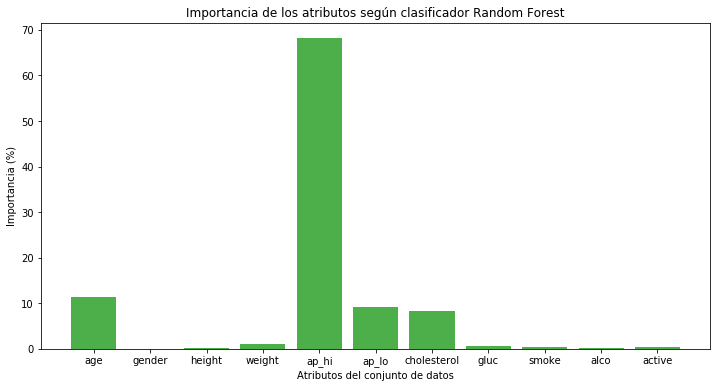

In [7]:
valoresX      = atributosDesarrollo.columns
valoresY      = 100 * gridSearchRF.best_estimator_.feature_importances_
figura, panel = matplotlib.pyplot.subplots(figsize = (12, 6))
panel.bar(valoresX, valoresY, color="#4daf4a")
panel.set_xlabel('Atributos del conjunto de datos')
panel.set_ylabel('Importancia (%)')
panel.set_title('Importancia de los atributos según clasificador Random Forest')
figura.show()

# 2. Clasificación utilizando *Gradient Boosting* (XGBoost)

In [24]:
clasificadorXGBoost = xgboost.XGBClassifier(n_estimators=100,
                                            max_depth=6,
                                            objective='binary:logistic',
                                            seed=0)

Calculamos meétricas utilizando el conjunto de test

In [25]:
parametrosXGB = { "learning_rate": [ 0.01, 0.05, 0.1, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.5 ] }
gridSearchXGB = sklearn.model_selection.GridSearchCV(estimator = clasificadorXGBoost, cv = 5, n_jobs = 4, 
                                                     param_grid = parametrosXGB, scoring = fbeta_scorer,
                                                     return_train_score=False)
gridSearchXGB.fit(X=atributosDesarrollo, y=objetivoDesarrollo)
performanceXGB = EvaluarPerformance(gridSearchXGB, parametrosXGB)
print(performanceXGB)

   learning_rate     valor          
                     media    desvio
0           0.01  0.685553  0.007512
1           0.05  0.701010  0.004458
2           0.10  0.704450  0.003873
3           0.15  0.704501  0.003103
4           0.20  0.705990  0.004723
5           0.25  0.705524  0.003009
6           0.30  0.705268  0.004621
7           0.35  0.704666  0.004212
8           0.40  0.702239  0.005203
9           0.45  0.702322  0.004546
10          0.50  0.700589  0.004991


/opt/anaconda3/envs/aprendizaje-automatico/lib/python3.7/site-packages/pandas/core/groupby/generic.py:1315: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


Buscamos la totalidad de las métricas para el mejor clasificador utilizando el conjunto de test.

In [26]:
prediccionesXGB = gridSearchXGB.best_estimator_.predict(atributosTest)
metricasXGB     = CalcularMetricas(objetivoTest, prediccionesXGB)
print("Mejor ajuste: ", gridSearchXGB.best_params_)
print("Métricas para el mejor ajuste: ", metricasXGB)

Mejor ajuste:  {'learning_rate': 0.2}
Métricas para el mejor ajuste:  {'accuracy': 0.7331428571428571, 'roc_auc': 0.732681761180918, 'precision': 0.7530492634246793, 'recall': 0.6859039099697013, 'f1': 0.7179099969797644, 'f2': 0.6983576695948527, 'TP': 4754, 'FP': 1559, 'TN': 5510, 'FN': 2177}


Graficamos la importancia de los features, según este clasificador.

/opt/anaconda3/envs/aprendizaje-automatico/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


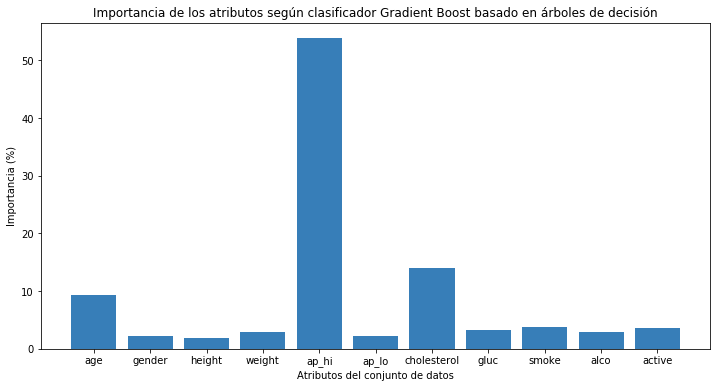

In [27]:
valoresX      = atributosDesarrollo.columns
valoresY      = 100 * gridSearchXGB.best_estimator_.feature_importances_
figura, panel = matplotlib.pyplot.subplots(figsize = (12, 6))
panel.bar(valoresX, valoresY, color="#377eb8")
panel.set_xlabel('Atributos del conjunto de datos')
panel.set_ylabel('Importancia (%)')
panel.set_title('Importancia de los atributos según clasificador Gradient Boost basado en árboles de decisión')
figura.show()

Antes de pasar al próximo clasificador, comparamos la importancia que los dos clasificadores evaluados le dan a cada uno de los atributos de entrada.

Text(0.5, 1.0, 'Comparativa de importancia de atributos entre modelos basandos en árboles')

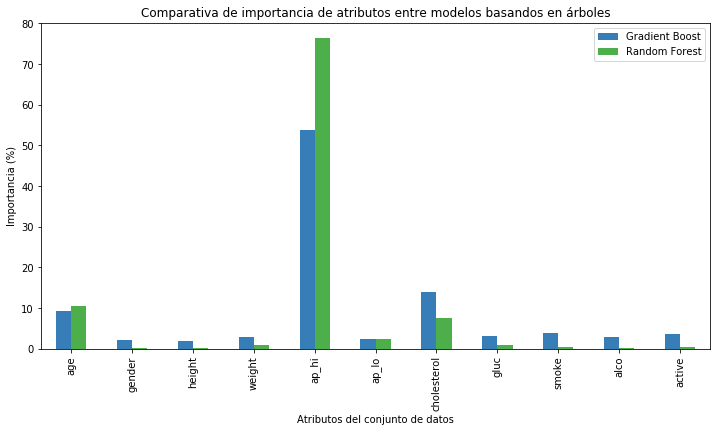

In [28]:
valoresZ    = 100 * gridSearchRF.best_estimator_.feature_importances_
comparativa = pandas.DataFrame(numpy.c_[valoresX, valoresY, valoresZ], index=valoresX)
comparativa.columns = [ "Atributo", "Gradient Boost", "Random Forest" ]
panel = comparativa.plot.bar(figsize = (12, 6), color=("#377eb8", "#4daf4a"))
panel.set_xlabel('Atributos del conjunto de datos')
panel.set_ylabel('Importancia (%)')
panel.set_title('Comparativa de importancia de atributos entre modelos basandos en árboles')

# 3. Clasificación utilizando *Ada Boosting* con *Naïve Bayes*

In [13]:
estimadorBase        = sklearn.naive_bayes.GaussianNB()
clasificadorAdaBoost = sklearn.ensemble.AdaBoostClassifier(n_estimators=100,
                                                           base_estimator=estimadorBase,
                                                           random_state=0)

Exploramos parámetros del clasificador (en este caso, solamente *learning_rate*) utilizando 5-Fold Cross Validation

In [14]:
parametrosAB = { "learning_rate": [ 0.01, 0.05, 0.1, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0 ] }
gridSearchAB = sklearn.model_selection.GridSearchCV(estimator = clasificadorAdaBoost, cv = 5, n_jobs = 4, 
                                                    param_grid = parametrosAB, scoring = fbeta_scorer,
                                                    return_train_score=False)
gridSearchAB.fit(X=atributosDesarrollo, y=objetivoDesarrollo)
performanceAB = EvaluarPerformance(gridSearchAB, parametrosAB)
print(performanceAB)

   learning_rate     valor          
                     media    desvio
0           0.01  0.682457  0.002899
1           0.05  0.696262  0.003370
2           0.10  0.695179  0.003703
3           0.15  0.694327  0.004319
4           0.20  0.697731  0.027363
5           0.25  0.714964  0.058381
6           0.30  0.693417  0.098171
7           0.35  0.595786  0.218457
8           0.40  0.560959  0.244862
9           0.45  0.585916  0.119004
10          0.50  0.559493  0.321955
11          0.60  0.597232  0.337441
12          0.70  0.504293  0.205470
13          0.80  0.422852  0.331645
14          0.90  0.611174  0.167772
15          1.00  0.324127  0.289668


/opt/anaconda3/envs/aprendizaje-automatico/lib/python3.7/site-packages/pandas/core/groupby/generic.py:1315: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


Obtenemos todas las métricas del mejor clasificador utilizando el conjunto de *test*

In [15]:
prediccionesAB = gridSearchAB.best_estimator_.predict(atributosTest)
metricasAB     = CalcularMetricas(objetivoTest, prediccionesAB)
print("Mejor ajuste: ", gridSearchAB.best_params_)
print("Métricas para el mejor ajuste: ", metricasAB)

Mejor ajuste:  {'learning_rate': 0.25}
Métricas para el mejor ajuste:  {'accuracy': 0.6707142857142857, 'roc_auc': 0.671404746081553, 'precision': 0.6458464245318587, 'recall': 0.741451450007214, 'f1': 0.6903546480386888, 'f2': 0.7201311622432106, 'TP': 5139, 'FP': 2818, 'TN': 4251, 'FN': 1792}


Es interesante observar al valor medio de la métrica *ROC AUC* en función del valor de *learning_rate*.

/opt/anaconda3/envs/aprendizaje-automatico/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


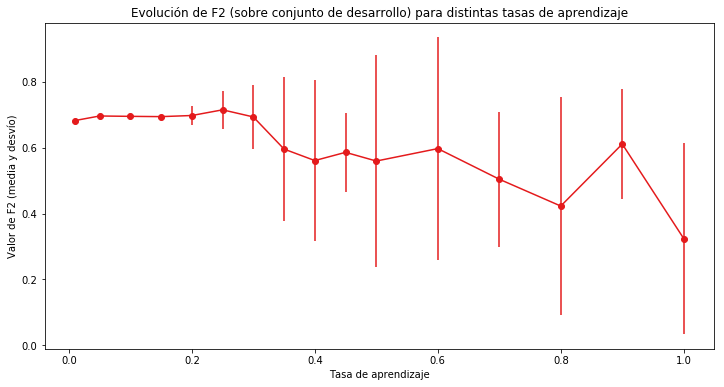

In [16]:
valoresX = list(performanceAB['learning_rate'])
valoresY = list(performanceAB['valor']['media'])
valoresZ = list(performanceAB['valor']['desvio'])
figura, panel = matplotlib.pyplot.subplots(figsize = (12, 6))
panel.errorbar(valoresX, valoresY, yerr=valoresZ, fmt='-o', color="#e41a1c")
panel.set_xlabel('Tasa de aprendizaje')
panel.set_ylabel('Valor de F2 (media y desvío)')
panel.set_title('Evolución de F2 (sobre conjunto de desarrollo) para distintas tasas de aprendizaje')
figura.show()

In [19]:
# Entrerar Random Forest
def f2_score(y_true, y_pred, labels=None, pos_label=1, average="binary", sample_weight=None):
    return sklearn.metrics.fbeta_score(y_true, y_pred, 2, labels, pos_label, average, sample_weight)
    
modelos = [
    sklearn.ensemble.RandomForestClassifier(n_estimators=100, 
                                            criterion="gini", 
                                            max_depth=6,                                                                    
                                            random_state=0),
    xgboost.XGBClassifier(n_estimators=100,
                          max_depth=6,
                          learning_rate=0.20,
                          objective='binary:logistic',
                          seed=0),
    sklearn.ensemble.AdaBoostClassifier(n_estimators=100,
                                        base_estimator=sklearn.naive_bayes.GaussianNB(),
                                        learning_rate=0.25,
                                        random_state=0)  
]
S_train, S_test = vecstack.stacking(modelos, atributosDesarrollo, objetivoDesarrollo, atributosTest, 
                                    n_folds = 5, shuffle = True, metric=f2_score, verbose = 2)

# Efectuar meta-modelo con XGBoost
metaModelo           = xgboost.XGBClassifier(n_estimators=100, learning_rate=0.25, max_depth=6, 
                                             objective='binary:logistic', seed=0)
modeloFinal          = metaModelo.fit(numpy.c_[S_train], objetivoDesarrollo)
prediccionesStacking = modeloFinal.predict(numpy.c_[S_test])
metricasStacking     = CalcularMetricas(objetivoTest, prediccionesStacking)
print("Métricas para stacking: ", metricasStacking)

task:         [regression]
metric:       [f2_score]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [RandomForestClassifier]
    fold  0:  [0.67156827]
    fold  1:  [0.67660934]
    fold  2:  [0.68785579]
    fold  3:  [0.67465114]
    fold  4:  [0.67571069]
    ----
    MEAN:     [0.67727904] + [0.00555508]
    FULL:     [0.67728776]

model  1:     [XGBClassifier]
    fold  0:  [0.69597927]
    fold  1:  [0.70207548]
    fold  2:  [0.71304881]
    fold  3:  [0.70836636]
    fold  4:  [0.70339014]
    ----
    MEAN:     [0.70457201] + [0.00579168]
    FULL:     [0.70457906]

model  2:     [AdaBoostClassifier]
    fold  0:  [0.76503355]
    fold  1:  [0.66355653]
    fold  2:  [0.60092593]
    fold  3:  [0.70936012]
    fold  4:  [0.74918842]
    ----
    MEAN:     [0.69761291] + [0.05975246]
    FULL:     [0.70033108]

Métricas para stacking:  {'accuracy': 0.7300714285714286, 'roc_auc': 0.7297079110074348, 'precision': 0.7442653440793552, 'recall': 0.6928293175587938, 'f